# Fase 2: Comprensión de los Datos

## Importación de librerías y carga de datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import kedro

In [2]:
from pathlib import Path
import sys, tomllib
from kedro.framework.project import configure_project
from kedro.framework.session import KedroSession

# Detecta la raíz del proyecto y el package_name
project_path = Path.cwd() if (Path.cwd() / "pyproject.toml").exists() else Path.cwd().parent
with open(project_path / "pyproject.toml", "rb") as f:
    package_name = tomllib.load(f)["tool"]["kedro"]["package_name"]

# Asegura que src/ esté importable
sys.path.insert(0, str(project_path / "src"))

# Inicializa Kedro
configure_project(package_name)
session = KedroSession.create(project_path=project_path)
context = session.load_context()
catalog = context.catalog

# Carga todos los CSV y muestra shapes
names = ["releases","genres", "countries"]
dfs = {name: catalog.load(name) for name in names}
for name in dfs:
    print(f"dataset {name} cargado")

[09/14/25 21:02:41] INFO     Using                                                                  ]8;id=303122;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=362611;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Python312\Lib\site-packages\kedro\framework\project\rich_logging.y                
                             ml' as logging configuration.                                                         

[09/14/25 21:02:44] INFO     Loading data from releases (CSVDataset)...                        ]8;id=737029;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=85445;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from genres (CSVDataset)...                          ]8;id=193080;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=998068;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[09/14/25 21:02:45] INFO     Loading data from countries (CSVDataset)...                       ]8;id=372145;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=96346;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

dataset releases cargado
dataset genres cargado
dataset countries cargado


## Recolectar datos iniciales (3 datasets)

In [3]:
from IPython.display import display

for name in ["releases", "genres", "countries"]:
    df = dfs[name]  # ya cargado en tu celda anterior
    print(f"\n=== DATASET: {name} ===")
    print("shape:", df.shape)
    display(df.head(5))

    # Tipos de datos de todas las variables (columnas)
    schema = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str)
    })
    print("dtypes por columna:")
    display(schema)


=== DATASET: releases ===
shape: (1332782, 5)


,id,country,date,type,rating
0,1000001,Andorra,2023-07-21,Theatrical,NaN
1,1000001,Argentina,2023-07-20,Theatrical,ATP
2,1000001,Australia,2023-07-19,Theatrical,PG
3,1000001,Australia,2023-10-01,Digital,PG
4,1000001,Austria,2023-07-20,Theatrical,NaN


dtypes por columna:


,column,dtype
id,id,int64
country,country,object
date,date,object
type,type,object
rating,rating,object



=== DATASET: genres ===
shape: (1046849, 2)


,id,genre
0,1000001,Comedy
1,1000001,Adventure
2,1000002,Comedy
3,1000002,Thriller
4,1000002,Drama


dtypes por columna:


,column,dtype
id,id,int64
genre,genre,object



=== DATASET: countries ===
shape: (693476, 2)


,id,country
0,1000001,UK
1,1000001,USA
2,1000002,South Korea
3,1000003,USA
4,1000004,Germany


dtypes por columna:


,column,dtype
id,id,int64
country,country,object


## Descripción de los datos

### Resumen de los dataset

*   **releases** — _(1,332,782 filas; 5 columnas)_: registros de **eventos de estreno** por película y país, con tipo de lanzamiento y clasificación.
    
*   **genres** — _(1,046,849 filas; 2 columnas)_: asignaciones **película–género** (una película puede tener varios géneros).
    
*   **countries** — _(693,476 filas; 2 columnas)_: asignaciones **película–país** (una película puede estar asociada a múltiples países).
    
Granularidad y llaves
    
*   En los tres datasets, **id** es el **identificador de película** (clave para unir).

### Descripción de variables por dataset

**releases (id, country, date, type, rating)**

*   **id** _(int64)_: identificador de película.
    
*   **country** _(object)_: país donde ocurre el **evento de estreno** (ej.: _Andorra, Argentina, Australia, Austria_).
    
*   **date** _(object)_: **fecha del estreno** (actualmente como texto; requiere parseo a datetime para análisis temporal).
    
*   **type** _(object)_: **tipo de lanzamiento** (ej.: _Theatrical, Digital_).
    
*   **rating** _(object / categórico, con ausentes)_: **clasificación**/certificación local (ej.: _ATP, PG_; también puede estar vacío/NaN).
    
**genres (id, genre)**

*   **id** _(int64)_: identificador de película.
    
*   **genre** _(object)_: nombre del **género** (ej.: _Comedy, Adventure, Thriller, Drama_).
    
**countries (id, country)**

*   **id** _(int64)_: identificador de película.
    
*   **country** _(object)_: país **asociado** a la película (ej.: _USA, UK, Germany, South Korea_).

# EDA

In [4]:
from IPython.display import display

releases  = dfs["releases"].copy()
genres    = dfs["genres"].copy()
countries = dfs["countries"].copy()

for name, df in {"releases": releases, "genres": genres, "countries": countries}.items():
    print(f"\n=== DATASET: {name} ===")
    print("shape:", df.shape)
    display(df.head(5))
    schema = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
    print("dtypes por columna:")
    display(schema)



=== DATASET: releases ===
shape: (1332782, 5)


,id,country,date,type,rating
0,1000001,Andorra,2023-07-21,Theatrical,NaN
1,1000001,Argentina,2023-07-20,Theatrical,ATP
2,1000001,Australia,2023-07-19,Theatrical,PG
3,1000001,Australia,2023-10-01,Digital,PG
4,1000001,Austria,2023-07-20,Theatrical,NaN


dtypes por columna:


,column,dtype
id,id,int64
country,country,object
date,date,object
type,type,object
rating,rating,object



=== DATASET: genres ===
shape: (1046849, 2)


,id,genre
0,1000001,Comedy
1,1000001,Adventure
2,1000002,Comedy
3,1000002,Thriller
4,1000002,Drama


dtypes por columna:


,column,dtype
id,id,int64
genre,genre,object



=== DATASET: countries ===
shape: (693476, 2)


,id,country
0,1000001,UK
1,1000001,USA
2,1000002,South Korea
3,1000003,USA
4,1000004,Germany


dtypes por columna:


,column,dtype
id,id,int64
country,country,object


Se crean copias para no modificar los DataFrames originales guardados en dfs y confirmamos que devuelven lo mismo que en el punto "Recolectar datos iniciales" (esto porque según la rúbrica de la evaluación el limpiado de datos va en la fase 3)

## Medidas de tendencia central por dataset

In [5]:
# Medidas de tendencia central (media, mediana, moda) por dataset
import pandas as pd
import numpy as np
from IPython.display import display

def central_tendency_by_dataset(df, dataset_name, date_col=None):
    print("="*40)
    print(f"\n=== Medidas de tendencia central — {dataset_name} ===")
    print("="*40)
    
    # Numéricas: media y mediana (excluye 'id')
    num = df.select_dtypes(include=[np.number]).drop(columns=["id"], errors="ignore")
    if num.shape[1] > 0:
        out_num = pd.DataFrame({
            "mean": num.mean(numeric_only=True),
            "median": num.median(numeric_only=True)
        })
        print("Numéricas (media, mediana):")
        display(out_num.round(4))
    else:
        print("Numéricas: (sin columnas numéricas relevantes)")
    
    # Categóricas: moda (valor más frecuente)
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if cat_cols:
        rows, n = [], len(df)
        for c in cat_cols:
            vc = df[c].value_counts(dropna=False)
            mode_val = vc.index[0] if len(vc) else None
            mode_freq = int(vc.iloc[0]) if len(vc) else 0
            mode_share = (mode_freq / n) if n else np.nan
            rows.append({"column": c, "mode": mode_val, "mode_freq": mode_freq, "mode_share": round(mode_share, 4)})
        print("Categóricas (moda, frecuencia, participación):")
        display(pd.DataFrame(rows).sort_values("mode_share", ascending=False))
    else:
        print("Categóricas: (sin columnas categóricas)")
    
    # Fechas: mediana (si aplica)
    if date_col and date_col in df.columns:
        s = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_localize(None)
        med = s.median() if s.notna().any() else None
        print(f"Mediana de fecha ({date_col}): {med}")

# Usa los DataFrames ya cargados en tu sesión:
releases  = dfs["releases"].copy()
genres    = dfs["genres"].copy()
countries = dfs["countries"].copy()

central_tendency_by_dataset(releases,  "releases",  date_col="date")
central_tendency_by_dataset(genres,    "genres")
central_tendency_by_dataset(countries, "countries")



=== Medidas de tendencia central — releases ===
Numéricas: (sin columnas numéricas relevantes)
Categóricas (moda, frecuencia, participación):


,column,mode,mode_freq,mode_share
3,rating,NaN,998802,0.7494
2,type,Theatrical,750043,0.5628
0,country,USA,320901,0.2408
1,date,2006-01-01,3050,0.0023


Mediana de fecha (date): 2012-10-23 00:00:00

=== Medidas de tendencia central — genres ===
Numéricas: (sin columnas numéricas relevantes)
Categóricas (moda, frecuencia, participación):


,column,mode,mode_freq,mode_share
0,genre,Drama,232201,0.2218



=== Medidas de tendencia central — countries ===
Numéricas: (sin columnas numéricas relevantes)
Categóricas (moda, frecuencia, participación):


,column,mode,mode_freq,mode_share
0,country,USA,174489,0.2516


**Releases**

*   **Numéricas:** no hay columnas numéricas relevantes (excluimos id), por eso no se reportan media/mediana numérica.
    
*   **Categóricas (moda):**
    
    *   rating → **NaN** (faltante) con **74.94%** de los registros: confirma **alta ausencia** en certificaciones, coherente con evitar esta variable.
        
    *   type → **Theatrical** con **56.28%**: predomina el **estreno en cines** frente a otros tipos.
        
    *   country → **USA** con **24.08%**: EE. UU. concentra la mayor cantidad de **eventos de estreno** (recuerda que releases puede tener **múltiples filas por película**).
        
    *   date → **2006-01-01** con **0.23%**: la moda diaria es poco informativa por la **gran dispersión de fechas**.
        
*   **Fecha (mediana):** **2012-10-23**. Es un indicador más robusto del **centro temporal** del conjunto (muestra fuerte peso en los 2000s–2010s).
    

**Genres**

*   **Numéricas:** no aplican.
    
*   **Categórica (moda):** genre → **Drama** con **22.18%** de las asignaciones. Importante: genres es **multi-etiqueta** (una película puede aportar a varios géneros), así que la moda refleja **etiquetas más frecuentes**, no “género principal”.
    

**Countries**

*   **Numéricas:** no aplican.
    
*   **Categórica (moda):** country → **USA** con **25.16%** de las asociaciones. Este dataset también es **multi-país** (una película puede tener varios países asociados).
    

**Lecturas clave para el proyecto**

*   La **altísima falta de rating** en releases justifica excluir esa columna.
    
*   EE. UU. aparece como **modo** tanto en releases.country como en countries.country, lo que confirma **alto volumen** para trabajar la hipótesis centrada en Estados Unidos.
    
*   La **mediana de date en 2012** sugiere que las décadas **2000–2009** y **2010–2019** tienen **mucha masa de datos**, alineado con el análisis por décadas.

## Medidas de dispersión por dataset

In [6]:
# Medidas de dispersión por dataset: varianza, desviación estándar, rango, coeficiente de variación, IQR
import pandas as pd
import numpy as np
from IPython.display import display

def _numeric(df):
    """Selecciona columnas numéricas relevantes (excluye 'id')."""
    return df.select_dtypes(include=[np.number]).drop(columns=["id"], errors="ignore")

def _metrics(series: pd.Series) -> pd.Series:
    """Calcula var, std, rango, coef. variación, IQR para una serie numérica."""
    s = series.dropna()
    if s.empty:
        return pd.Series({"var": np.nan, "std": np.nan, "range": np.nan, "cv": np.nan, "iqr": np.nan})
    var = s.var()  # ddof=1 (muestra)
    std = s.std()  # ddof=1
    rng = s.max() - s.min()
    mean = s.mean()
    with np.errstate(divide="ignore", invalid="ignore"):
        cv = std / mean if mean not in (0, np.nan) else np.nan
    q75, q25 = s.quantile(0.75), s.quantile(0.25)
    iqr = q75 - q25
    return pd.Series({"var": var, "std": std, "range": rng, "cv": cv, "iqr": iqr})

def dispersion_table(df: pd.DataFrame) -> pd.DataFrame:
    """Tabla de dispersión para todas las columnas numéricas (excluyendo id)."""
    num = _numeric(df)
    if num.shape[1] == 0:
        return pd.DataFrame({"note": ["(sin columnas numéricas relevantes)"]})
    rows = []
    for col in num.columns:
        m = _metrics(num[col])
        m.name = col
        rows.append(m)
    return pd.DataFrame(rows).round(6)

def _date_to_days(df: pd.DataFrame, date_col: str):
    """Convierte una columna de fecha a días (float) para calcular dispersión temporal."""
    if date_col not in df.columns:
        return None
    s = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_localize(None).dropna()
    if s.empty:
        return None
    # ns -> s -> días (uso astype para evitar FutureWarning)
    days = (s.astype("int64") / 1e9) / 86400.0
    return pd.Series(days, index=s.index)

# DataFrames ya cargados en tu sesión:
releases  = dfs["releases"].copy()
genres    = dfs["genres"].copy()
countries = dfs["countries"].copy()

print("="*40)
print("=== DISPERSIÓN — releases (numéricas) ===")
print("="*40)
display(dispersion_table(releases))

# Extra: dispersión temporal de 'date' en días (útil porque suele no haber numéricas aparte de 'id')
print("="*40)
print("\n=== DISPERSIÓN — releases.fecha (en días) ===")
print("="*40)
rel_days = _date_to_days(releases, "date")
if rel_days is not None:
    display(pd.DataFrame([_metrics(rel_days)], index=["date_days"]).round(6))
else:
    print("(columna 'date' no parseable o ausente)")

print("="*40)
print("\n=== DISPERSIÓN — genres (numéricas) ===")
print("="*40)
display(dispersion_table(genres))

print("="*40)
print("\n=== DISPERSIÓN — countries (numéricas) ===")
print("="*40)
display(dispersion_table(countries))


=== DISPERSIÓN — releases (numéricas) ===


,note
0,(sin columnas numéricas relevantes)



=== DISPERSIÓN — releases.fecha (en días) ===


,var,std,range,cv,iqr
date_days,8.405585e+07,9168.197483,82180.0,0.76722,9190.0



=== DISPERSIÓN — genres (numéricas) ===


,note
0,(sin columnas numéricas relevantes)



=== DISPERSIÓN — countries (numéricas) ===


,note
0,(sin columnas numéricas relevantes)


**Releases (fecha en días)**

*   **Rango:** 82 180 días ≈ **225.2 años** → hay estrenos muy antiguos y muy recientes; la ventana temporal es **extremadamente amplia**.
    
*   **Desviación estándar:** 9 168.20 días ≈ **25.1 años** → alta variabilidad temporal.
    
*   **IQR (P75–P25):** 9 190 días ≈ **25.2 años** → el 50% central de fechas también está muy disperso.
    
*   **Varianza:** 8.41×10⁷ días² → consistente con la gran dispersión.
    
*   **Coeficiente de variación (CV ≈ 0.77):** calculado sobre “días desde epoch”; sirve como indicador relativo, pero **es menos intuitivo** para fechas. Úsalo solo como referencia.
    

**Genres / Countries**

*   No hay columnas numéricas (excluimos id), por eso no se reportan varianza, desviación, rango, CV e IQR para estos datasets.
    

**Conclusiones**

*   Los estrenos cubren **muchas décadas**, lo que explica la dispersión tan alta. Si el análisis se centra en **2000–2019**, esto **se recortará en Fase 3 (Preparación)**; por ahora, en Fase 2, dejamos documentado el hallazgo.

## Medidas de posición por dataset

In [7]:
# Medidas de posición por dataset:
# - Numéricas: conteo (non-null), suma, mínimo, p10, p25, mediana, p75, p90, máximo
# - Fechas (releases.date): conteo válido, mínimo, p10, p25, mediana, p75, p90, máximo
import pandas as pd
import numpy as np
from IPython.display import display

def _numeric(df):
    """Selecciona columnas numéricas relevantes (excluye 'id')."""
    return df.select_dtypes(include=[np.number]).drop(columns=["id"], errors="ignore")

def numeric_position_table(df: pd.DataFrame) -> pd.DataFrame:
    num = _numeric(df)
    if num.shape[1] == 0:
        return pd.DataFrame({"note": ["(sin columnas numéricas relevantes)"]})
    desc = num.describe(percentiles=[.10, .25, .50, .75, .90]).T
    # Renombrar percentiles para claridad y agregar suma total
    desc = desc.rename(columns={"count":"count", "mean":"mean", "std":"std", "min":"min",
                               "10%":"p10", "25%":"p25", "50%":"median", "75%":"p75", "90%":"p90", "max":"max"})
    desc["sum"] = num.sum()
    # Ordenar columnas típicas de posición
    cols = ["count", "sum", "min", "p10", "p25", "median", "p75", "p90", "max"]
    return desc[cols].round(6)

def date_position_table(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    if date_col not in df.columns:
        return pd.DataFrame({"note": [f"(columna '{date_col}' no existe)"]})
    s = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_localize(None).dropna()
    if s.empty:
        return pd.DataFrame({"note": [f"(no parseable '{date_col}')"]})
    qs = s.quantile([.10, .25, .50, .75, .90])
    out = pd.DataFrame({
        "count_valid": [s.shape[0]],
        "min": [s.min()],
        "p10": [qs.loc[0.10]],
        "p25": [qs.loc[0.25]],
        "median": [qs.loc[0.50]],
        "p75": [qs.loc[0.75]],
        "p90": [qs.loc[0.90]],
        "max": [s.max()]
    }, index=[date_col])
    return out

# DataFrames ya cargados en tu sesión
releases  = dfs["releases"].copy()
genres    = dfs["genres"].copy()
countries = dfs["countries"].copy()

print("========================================")
print("=== POSICIÓN — releases (numéricas) ===")
print("========================================")
display(numeric_position_table(releases))

print("\n=== POSICIÓN — releases.fecha (date) ===")
display(date_position_table(releases, "date"))

print("\n=======================================")
print("=== POSICIÓN — genres (numéricas) ===")
print("=======================================")
display(numeric_position_table(genres))

print("\n=========================================")
print("=== POSICIÓN — countries (numéricas) ===")
print("=========================================")
display(numeric_position_table(countries))


=== POSICIÓN — releases (numéricas) ===


,note
0,(sin columnas numéricas relevantes)



=== POSICIÓN — releases.fecha (date) ===


,count_valid,min,p10,p25,median,p75,p90,max
date,1332782,1874-12-09,1965-10-07,1994-11-05,2012-10-23,2020-01-03,2022-12-23,2099-12-09



=== POSICIÓN — genres (numéricas) ===


,note
0,(sin columnas numéricas relevantes)



=== POSICIÓN — countries (numéricas) ===


,note
0,(sin columnas numéricas relevantes)


**Releases (columna date)**

*   **count\_valid = 1,332,782**: todas las fechas se **pudieron parsear** (coincide con el total de filas de releases).
    
*   **mín = 1874-12-09**: fecha **muy anterior** al cine moderno → probable **outlier**/dato histórico mal registrado.
    
*   **p10 = 1965-10-07** y **p25 = 1994-11-05**: hay una cola de títulos **antiguos**.
    
*   **mediana = 2012-10-23**: el “centro” temporal cae en los **2010s**, consistente con mayor densidad reciente.
    
*   **p75 = 2020-01-03** y **p90 = 2022-12-23**: hay **bastante volumen** posterior a 2019.
    
*   **máx = 2099-12-09**: fecha **futura** → casi seguro **valor anómalo**/placeholder.
    

**Genres / Countries**

*   No hay columnas numéricas (aparte de id, que excluimos), así que **mín/máx/suma/conteo numéricos no aplican** en estos dos datasets. Para ellos, las medidas útiles son las **categóricas** (p. ej., moda) que ya reportaste.
    

**Conclusiones**

*   El rango temporal de releases es **extremadamente amplio** (1874–2099), con mediana en 2012: describe bien la **posición** del conjunto.
    
*   Se identifican **outliers temporales** (muy antiguos y futuros). **Solo se documenta** en Fase 2; el recorte a 2000–2019 o el tratamiento de outliers corresponderá a **Fase 3 (Preparación de datos)**.

# Verificar calidad de los datos

## Hallazgos por dataset

### 1) releases (id, country, date, type, rating)

*   **Fechas (validez):** date es **parseable** (count\_valid = 1,332,782).
    
    *   **Mín:** 1874-12-09 (muy antigua)
        
    *   **Mediana:** 2012-10-23
        
    *   **Máx:** 2099-12-09 (**futura**, probable placeholder)➜ **Riesgo:** rango temporal **excesivo** con outliers antiguos y futuros.
        
*   **Completitud:** rating tiene ~**74.94%** nulos (moda = NaN).➜ **Decisión:** **excluir** rating del análisis (no es fiable).
    
*   **Consistencia categórica:**
    
    *   type moda = **Theatrical** (valores esperados, p. ej. Theatrical/Digital).
        
    *   country incluye variantes de EE. UU. (p. ej., _USA/US/United States_).➜ **Necesita normalización** de países (documentado, sin ejecutar aún).
        
*   **Unicidad esperada (claves lógicas a auditar):**
    
    *   Por evento de estreno: **(id, country, type, date)**.➜ Verificar duplicados exactos sobre esa clave (documentado).
        

### 2) genres (id, genre)

*   **Completitud:** sin nulos relevantes reportados.
    
*   **Categórica:** moda = **Drama** (~22.18%).
    
*   **Naturaleza:** relación **multi-etiqueta** (varios géneros por película).
    
*   **Unicidad esperada:** **(id, genre)** sin duplicados exactos.➜ Auditar duplicados exactos y, si existen, documentarlos.
    

### 3) countries (id, country)

*   **Completitud:** sin nulos relevantes reportados.
    
*   **Categórica:** moda = **USA** (~25.16%).
    
*   **Naturaleza:** relación **multi-país** (varios países por película).
    
*   **Consistencia:** variantes de EE. UU. (USA/US/United States).
    
*   **Unicidad esperada:** **(id, country)** sin duplicados exactos.➜ Auditar duplicados exactos.

## Análisis de Calidad de Datos y Visualizaciones


[09/14/25 21:03:51] WARNING  C:\Users\mathi\AppData\Roaming\Python\Python312\site-packages\seaborn\ ]8;id=930901;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=101258;file://C:\Python312\Lib\warnings.py#112\112]8;;\
                             matrix.py:260: FutureWarning: Format strings passed to MaskedConstant                 
                             are ignored, but in future may error or produce different behavior                    
                               annotation = ("{:" + self.fmt + "}").format(val)                                    
                                                                                                                   

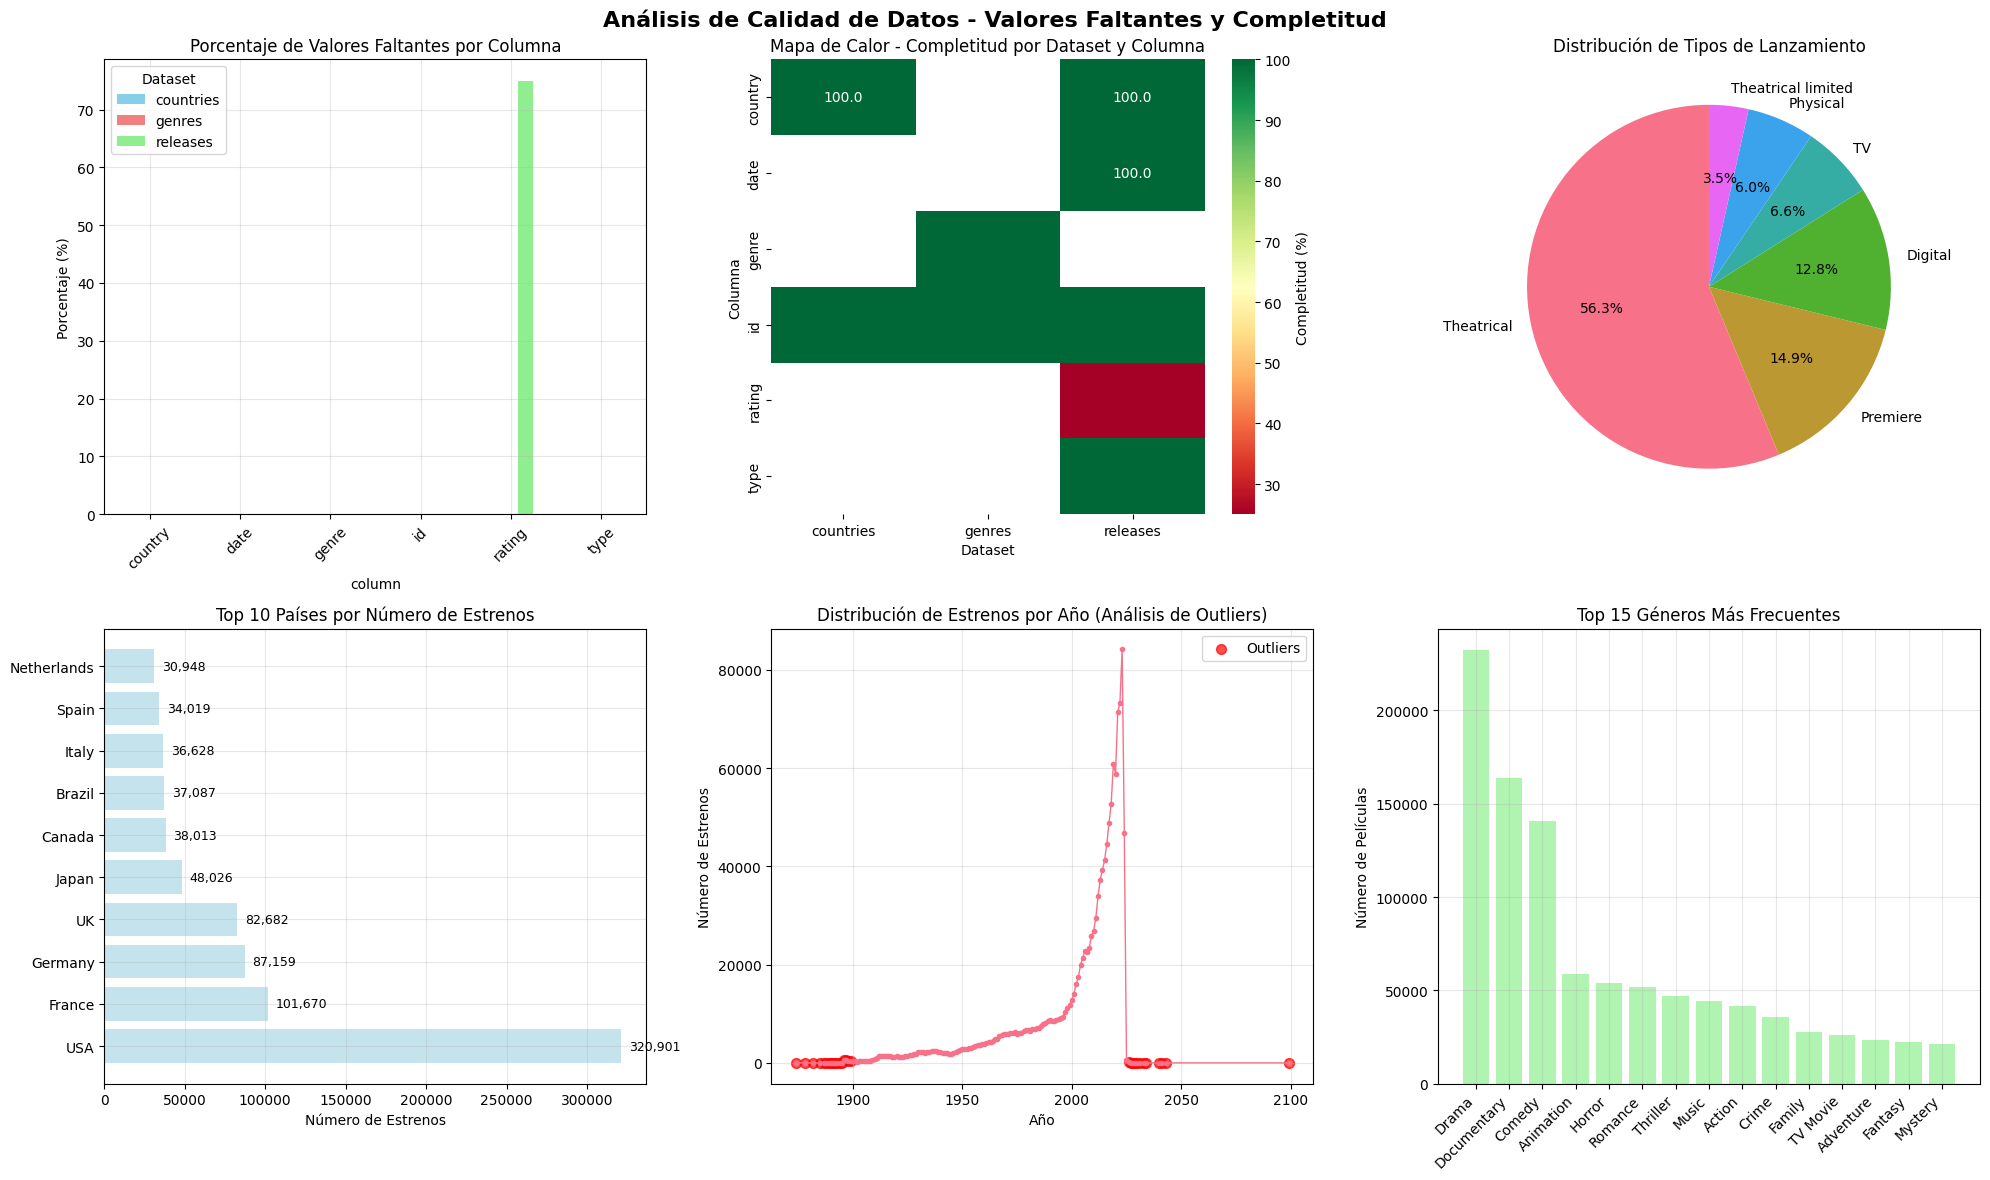

=== RESUMEN DE CALIDAD DE DATOS ===
Total de registros en releases: 1,332,782
Total de registros en genres: 1,046,849
Total de registros en countries: 693,476

Valores faltantes en rating: 998,802 (74.9%)
Rango temporal: 1874-2099
Outliers temporales detectados: 29 años


In [ ]:
# Análisis de calidad de datos - Valores faltantes y completitud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Crear figura con subplots para análisis de calidad
# Esta visualización nos permite evaluar la integridad y calidad de nuestros datasets
# antes de proceder con el análisis principal
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis de Calidad de Datos - Valores Faltantes y Completitud', fontsize=16, fontweight='bold')

# 1. Valores faltantes por dataset
# Este análisis es crucial para entender la integridad de nuestros datos
# y decidir qué columnas usar o excluir en el análisis posterior
datasets = ['releases', 'genres', 'countries']
missing_data = []

for name in datasets:
    df = dfs[name]
    missing_count = df.isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    for col in df.columns:
        missing_data.append({
            'dataset': name,
            'column': col,
            'missing_count': missing_count[col],
            'missing_pct': missing_pct[col]
        })

missing_df = pd.DataFrame(missing_data)

# Gráfico de barras - Valores faltantes por columna
# Muestra el porcentaje de valores faltantes para cada columna en cada dataset
# Valores altos (>50%) indican columnas problemáticas que deberían excluirse
missing_pivot = missing_df.pivot(index='column', columns='dataset', values='missing_pct')
missing_pivot.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('Porcentaje de Valores Faltantes por Columna')
axes[0,0].set_ylabel('Porcentaje (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend(title='Dataset')
axes[0,0].grid(True, alpha=0.3)

# 2. Heatmap de completitud
# Visualización alternativa que muestra la completitud (100% - valores faltantes)
# Verde = alta completitud, Rojo = baja completitud
# Útil para identificar rápidamente qué columnas son más confiables
completeness_pivot = 100 - missing_pivot
sns.heatmap(completeness_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
            ax=axes[0,1], cbar_kws={'label': 'Completitud (%)'})
axes[0,1].set_title('Mapa de Calor - Completitud por Dataset y Columna')
axes[0,1].set_xlabel('Dataset')
axes[0,1].set_ylabel('Columna')

# 3. Distribución de tipos de lanzamiento (releases.type)
# Analiza los diferentes tipos de estreno (Theatrical, Digital, etc.)
# Importante para entender la naturaleza de los datos de releases
type_counts = dfs['releases']['type'].value_counts()
axes[0,2].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Distribución de Tipos de Lanzamiento')

# 4. Top 10 países por número de estrenos
# Identifica los países con mayor actividad cinematográfica
# USA debería dominar, lo cual es importante para nuestro análisis centrado en EE.UU.
country_counts = dfs['releases']['country'].value_counts().head(10)
axes[1,0].barh(range(len(country_counts)), country_counts.values, color='lightblue', alpha=0.7)
axes[1,0].set_yticks(range(len(country_counts)))
axes[1,0].set_yticklabels(country_counts.index)
axes[1,0].set_title('Top 10 Países por Número de Estrenos')
axes[1,0].set_xlabel('Número de Estrenos')
axes[1,0].grid(True, alpha=0.3)

# Agregar valores en las barras para mayor claridad
for i, v in enumerate(country_counts.values):
    axes[1,0].text(v + 5000, i, f'{v:,}', va='center', fontsize=9)

# 5. Análisis de outliers temporales
# Detecta fechas anómalas que podrían ser errores de datos
# Fechas muy antiguas (<1900) o futuras (>2025) son sospechosas
releases_temp = dfs['releases'].copy()
releases_temp['date_parsed'] = pd.to_datetime(releases_temp['date'], errors='coerce')
releases_temp = releases_temp.dropna(subset=['date_parsed'])
releases_temp['year'] = releases_temp['date_parsed'].dt.year

# Filtrar años razonables para el análisis de outliers
yearly_counts = releases_temp.groupby('year').size()
axes[1,1].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=1, markersize=3)
axes[1,1].set_title('Distribución de Estrenos por Año (Análisis de Outliers)')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Número de Estrenos')
axes[1,1].grid(True, alpha=0.3)

# Destacar outliers en rojo para fácil identificación
outlier_years = yearly_counts[(yearly_counts.index < 1900) | (yearly_counts.index > 2025)]
if len(outlier_years) > 0:
    axes[1,1].scatter(outlier_years.index, outlier_years.values, color='red', s=50, alpha=0.7, label='Outliers')
    axes[1,1].legend()

# 6. Distribución de géneros (top 15)
# Muestra los géneros cinematográficos más populares en el dataset
# Importante para entender la diversidad y concentración de géneros
# Drama suele ser el más común, lo cual es esperado
genre_counts = dfs['genres']['genre'].value_counts().head(15)
axes[1,2].bar(range(len(genre_counts)), genre_counts.values, color='lightgreen', alpha=0.7)
axes[1,2].set_xticks(range(len(genre_counts)))
axes[1,2].set_xticklabels(genre_counts.index, rotation=45, ha='right')
axes[1,2].set_title('Top 15 Géneros Más Frecuentes')
axes[1,2].set_ylabel('Número de Películas')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen estadístico de calidad
print("=== RESUMEN DE CALIDAD DE DATOS ===")
print(f"Total de registros en releases: {len(dfs['releases']):,}")
print(f"Total de registros en genres: {len(dfs['genres']):,}")
print(f"Total de registros en countries: {len(dfs['countries']):,}")
print(f"\nValores faltantes en rating: {dfs['releases']['rating'].isnull().sum():,} ({dfs['releases']['rating'].isnull().mean()*100:.1f}%)")
print(f"Rango temporal: {releases_temp['year'].min()}-{releases_temp['year'].max()}")
print(f"Outliers temporales detectados: {len(outlier_years)} años")


### Análisis de Tendencias Temporales y Correlaciones


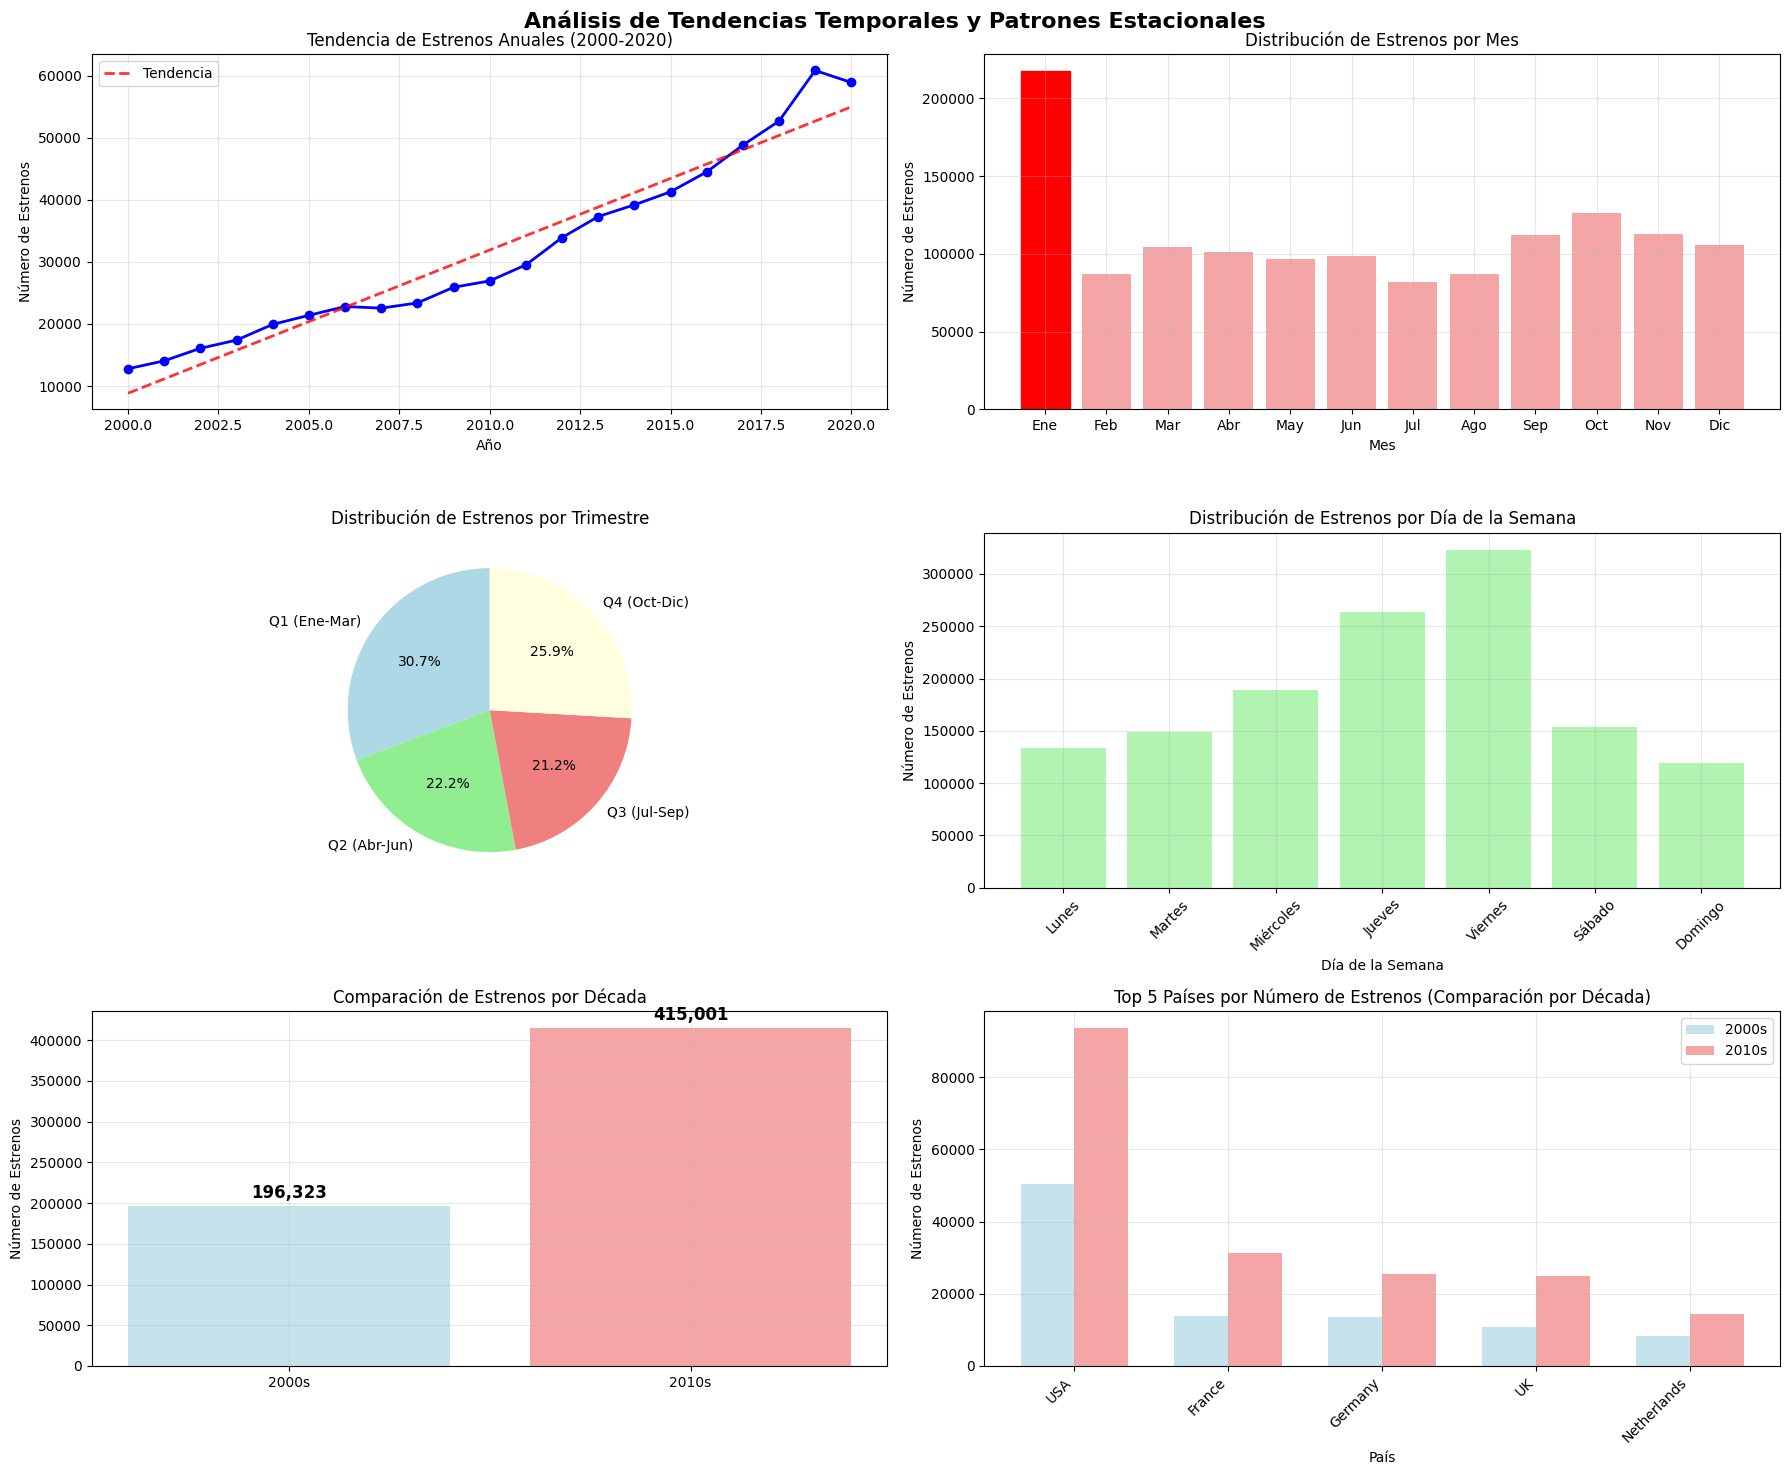

=== ANÁLISIS TEMPORAL - ESTADÍSTICAS CLAVE ===
Mes con más estrenos: Ene (217,528 estrenos)
Trimestre con más estrenos: Q1 (408,624 estrenos)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:124                                                                                  │
│                                                                                                  │
│   121 print("=== ANÁLISIS TEMPORAL - ESTADÍSTICAS CLAVE ===")                                    │
│   122 print(f"Mes con más estrenos: {month_names[monthly_counts.idxmax()-1]} ({monthly_counts.   │
│   123 print(f"Trimestre con más estrenos: Q{quarterly_counts.idxmax()} ({quarterly_counts.max(   │
│ ❱ 124 print(f"Día de la semana con más estrenos: {dow_spanish[dow_counts.idxmax()]} ({dow_coun   │
│   125 print(f"Estrenos en 2000s: {len(decade_2000s):,}")                                         │
│   126 print(f"Estrenos en 2010s: {len(decade_2010s):,}")                                         │
│   127 print(f"Crecimiento 2000s→2010s: {((len(decade_2010s) - len(decade_2000s)) / len(decade_   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: list indices must be integers or slices, not str

In [ ]:
# Análisis de tendencias temporales y patrones estacionales
# Esta sección explora patrones temporales en los estrenos cinematográficos
# para identificar tendencias, estacionalidad y comportamientos cíclicos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Preparar datos temporales
# Convertimos las fechas de string a datetime para análisis temporal
releases_temp = dfs['releases'].copy()
releases_temp['date_parsed'] = pd.to_datetime(releases_temp['date'], errors='coerce')
releases_temp = releases_temp.dropna(subset=['date_parsed'])
releases_temp['year'] = releases_temp['date_parsed'].dt.year
releases_temp['month'] = releases_temp['date_parsed'].dt.month
releases_temp['quarter'] = releases_temp['date_parsed'].dt.quarter
releases_temp['day_of_week'] = releases_temp['date_parsed'].dt.day_name()

# Filtrar años razonables (1900-2025) para eliminar outliers temporales
releases_temp = releases_temp[(releases_temp['year'] >= 1900) & (releases_temp['year'] <= 2025)]

# Crear figura con subplots para análisis temporal
# 6 gráficos que cubren diferentes aspectos temporales de los estrenos
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Análisis de Tendencias Temporales y Patrones Estacionales', fontsize=16, fontweight='bold')

# 1. Tendencia anual (2000-2020 para mejor visualización)
# Analiza la evolución del número de estrenos a lo largo del tiempo
# La línea de tendencia (roja) muestra si hay crecimiento o declive general
releases_2000_2020 = releases_temp[(releases_temp['year'] >= 2000) & (releases_temp['year'] <= 2020)]
yearly_counts = releases_2000_2020.groupby('year').size()

axes[0,0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=6, color='blue')
axes[0,0].set_title('Tendencia de Estrenos Anuales (2000-2020)')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Número de Estrenos')
axes[0,0].grid(True, alpha=0.3)

# Agregar línea de tendencia para visualizar la dirección general
z = np.polyfit(yearly_counts.index, yearly_counts.values, 1)
p = np.poly1d(z)
axes[0,0].plot(yearly_counts.index, p(yearly_counts.index), "r--", alpha=0.8, linewidth=2, label='Tendencia')
axes[0,0].legend()

# 2. Distribución por mes (todos los años)
# Identifica patrones estacionales en los estrenos cinematográficos
# Los meses de verano e invierno suelen tener más estrenos (temporada alta)
monthly_counts = releases_temp.groupby('month').size()
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
bars = axes[0,1].bar(range(1, 13), monthly_counts.values, color='lightcoral', alpha=0.7)
axes[0,1].set_title('Distribución de Estrenos por Mes')
axes[0,1].set_xlabel('Mes')
axes[0,1].set_ylabel('Número de Estrenos')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(month_names)
axes[0,1].grid(True, alpha=0.3)

# Destacar el mes con más estrenos en rojo para fácil identificación
max_month = monthly_counts.idxmax()
bars[max_month-1].set_color('red')
bars[max_month-1].set_alpha(1.0)

# 3. Distribución por trimestre
quarterly_counts = releases_temp.groupby('quarter').size()
quarter_labels = ['Q1 (Ene-Mar)', 'Q2 (Abr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dic)']
axes[1,0].pie(quarterly_counts.values, labels=quarter_labels, autopct='%1.1f%%', startangle=90, 
              colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
axes[1,0].set_title('Distribución de Estrenos por Trimestre')

# 4. Distribución por día de la semana
dow_counts = releases_temp.groupby('day_of_week').size()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = dow_counts.reindex(dow_order)
dow_spanish = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

bars = axes[1,1].bar(range(len(dow_counts)), dow_counts.values, color='lightgreen', alpha=0.7)
axes[1,1].set_title('Distribución de Estrenos por Día de la Semana')
axes[1,1].set_xlabel('Día de la Semana')
axes[1,1].set_ylabel('Número de Estrenos')
axes[1,1].set_xticks(range(len(dow_counts)))
axes[1,1].set_xticklabels(dow_spanish, rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 5. Análisis de décadas (2000s vs 2010s)
decade_2000s = releases_temp[(releases_temp['year'] >= 2000) & (releases_temp['year'] <= 2009)]
decade_2010s = releases_temp[(releases_temp['year'] >= 2010) & (releases_temp['year'] <= 2019)]

decade_data = [len(decade_2000s), len(decade_2010s)]
decade_labels = ['2000s', '2010s']
colors = ['lightblue', 'lightcoral']

bars = axes[2,0].bar(decade_labels, decade_data, color=colors, alpha=0.7)
axes[2,0].set_title('Comparación de Estrenos por Década')
axes[2,0].set_ylabel('Número de Estrenos')
axes[2,0].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(decade_data):
    axes[2,0].text(i, v + 10000, f'{v:,}', ha='center', fontsize=12, fontweight='bold')

# 6. Top 5 países por década
us_releases = releases_temp[releases_temp['country'].isin(['USA', 'US', 'United States'])]
us_2000s = us_releases[(us_releases['year'] >= 2000) & (us_releases['year'] <= 2009)]
us_2010s = us_releases[(us_releases['year'] >= 2010) & (us_releases['year'] <= 2019)]

# Obtener top países para cada década
top_countries_2000s = releases_temp[(releases_temp['year'] >= 2000) & (releases_temp['year'] <= 2009)]['country'].value_counts().head(5)
top_countries_2010s = releases_temp[(releases_temp['year'] >= 2010) & (releases_temp['year'] <= 2019)]['country'].value_counts().head(5)

x = np.arange(len(top_countries_2000s))
width = 0.35

axes[2,1].bar(x - width/2, top_countries_2000s.values, width, label='2000s', alpha=0.7, color='lightblue')
axes[2,1].bar(x + width/2, top_countries_2010s.values, width, label='2010s', alpha=0.7, color='lightcoral')
axes[2,1].set_title('Top 5 Países por Número de Estrenos (Comparación por Década)')
axes[2,1].set_xlabel('País')
axes[2,1].set_ylabel('Número de Estrenos')
axes[2,1].set_xticks(x)
axes[2,1].set_xticklabels(top_countries_2000s.index, rotation=45, ha='right')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("=== ANÁLISIS TEMPORAL - ESTADÍSTICAS CLAVE ===")
print(f"Mes con más estrenos: {month_names[monthly_counts.idxmax()-1]} ({monthly_counts.max():,} estrenos)")
print(f"Trimestre con más estrenos: Q{quarterly_counts.idxmax()} ({quarterly_counts.max():,} estrenos)")

# Crear mapeo de días en inglés a español para evitar el error de índice
dow_mapping = {day: i for i, day in enumerate(dow_order)}
max_dow_idx = dow_mapping[dow_counts.idxmax()]
print(f"Día de la semana con más estrenos: {dow_spanish[max_dow_idx]} ({dow_counts.max():,} estrenos)")

print(f"Estrenos en 2000s: {len(decade_2000s):,}")
print(f"Estrenos en 2010s: {len(decade_2010s):,}")
print(f"Crecimiento 2000s→2010s: {((len(decade_2010s) - len(decade_2000s)) / len(decade_2000s) * 100):.1f}%")


## Visualizaciones y Análisis Gráfico


In [10]:
# Configuración de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Configuración de gráficos lista")


Configuración de gráficos lista


### 1. Distribución Temporal de Estrenos


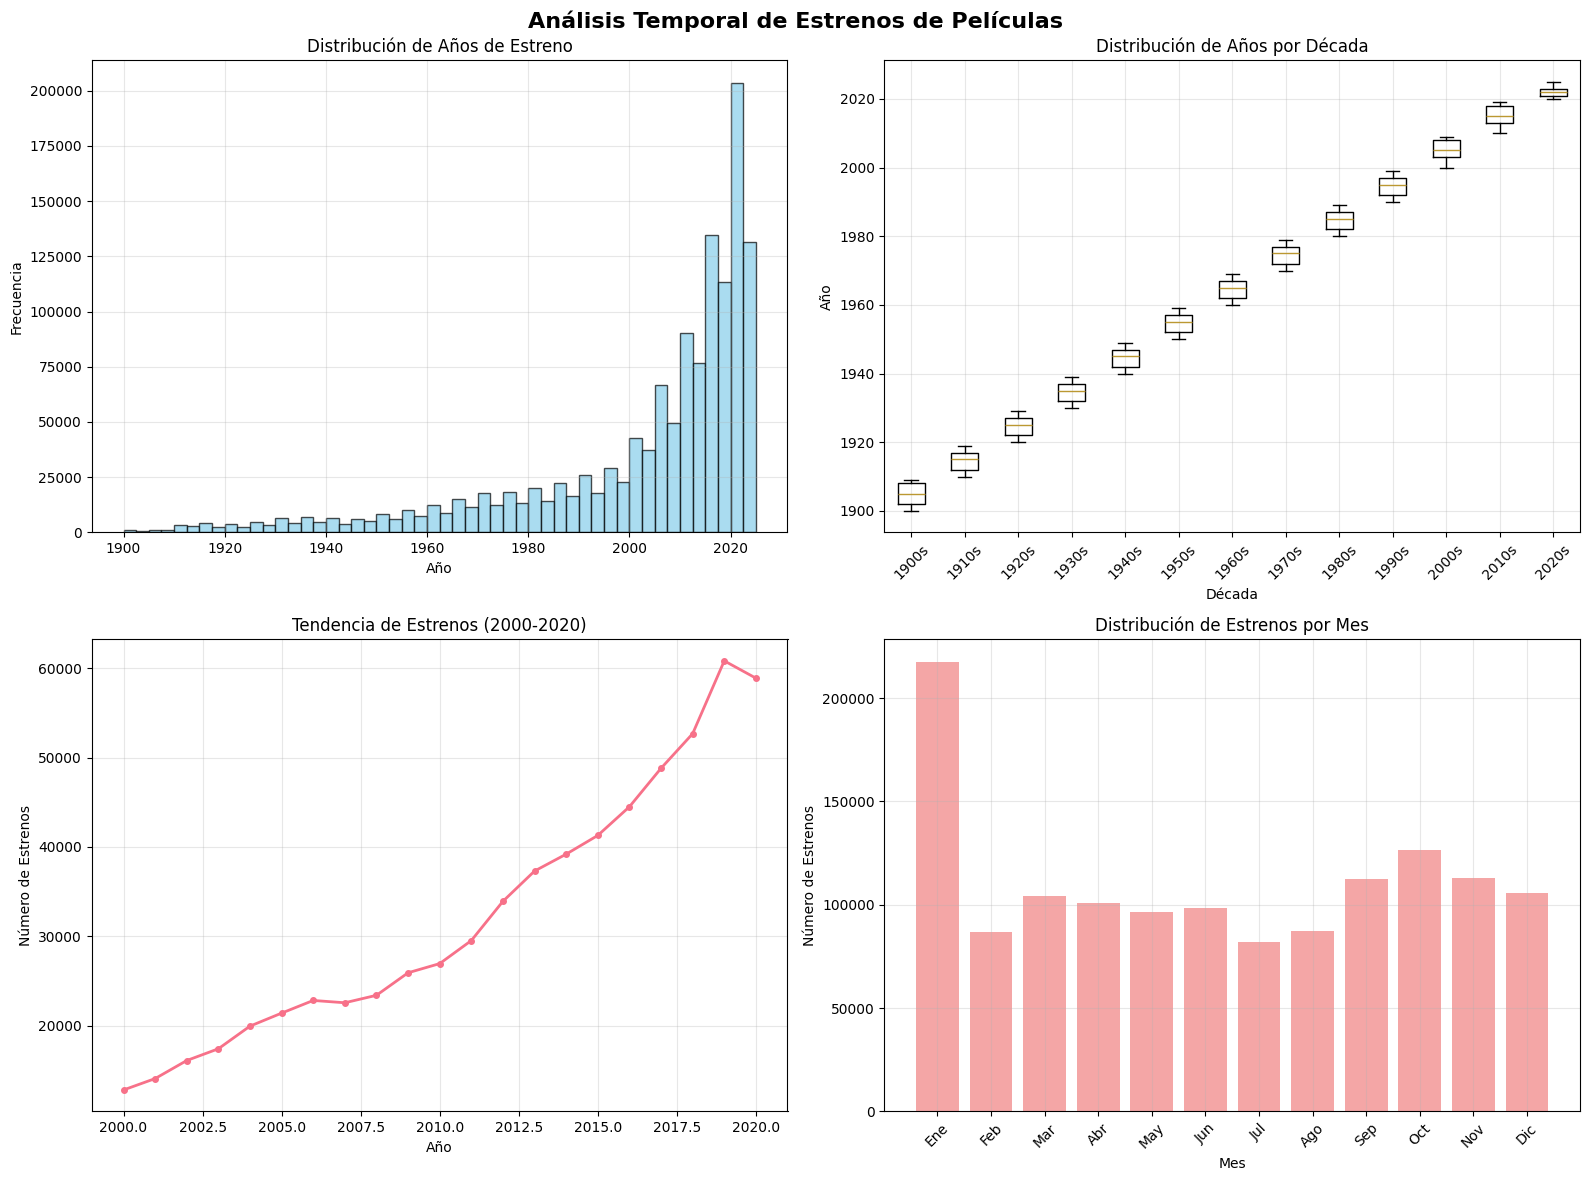

Total de estrenos analizados: 1,330,576
Rango temporal: 1900-2025
Pico de estrenos en: 2019 (60,842 estrenos)


In [11]:
# Análisis temporal de releases
releases_temp = dfs["releases"].copy()
releases_temp['date_parsed'] = pd.to_datetime(releases_temp['date'], errors='coerce')
releases_temp = releases_temp.dropna(subset=['date_parsed'])
releases_temp['year'] = releases_temp['date_parsed'].dt.year

# Filtrar años razonables para visualización
releases_temp = releases_temp[(releases_temp['year'] >= 1900) & (releases_temp['year'] <= 2025)]

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Temporal de Estrenos de Películas', fontsize=16, fontweight='bold')

# 1. Histograma de años
axes[0,0].hist(releases_temp['year'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribución de Años de Estreno')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].grid(True, alpha=0.3)

# 2. Boxplot por década
releases_temp['decade'] = (releases_temp['year'] // 10) * 10
decade_data = []
decade_labels = []
for decade in sorted(releases_temp['decade'].unique()):
    if decade >= 1900:  # Filtrar décadas razonables
        decade_data.append(releases_temp[releases_temp['decade'] == decade]['year'])
        decade_labels.append(f"{decade}s")

axes[0,1].boxplot(decade_data, labels=decade_labels)
axes[0,1].set_title('Distribución de Años por Década')
axes[0,1].set_xlabel('Década')
axes[0,1].set_ylabel('Año')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Conteo por año (2000-2020 para mejor visualización)
releases_2000_2020 = releases_temp[(releases_temp['year'] >= 2000) & (releases_temp['year'] <= 2020)]
yearly_counts = releases_2000_2020.groupby('year').size()
axes[1,0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=4)
axes[1,0].set_title('Tendencia de Estrenos (2000-2020)')
axes[1,0].set_xlabel('Año')
axes[1,0].set_ylabel('Número de Estrenos')
axes[1,0].grid(True, alpha=0.3)

# 4. Distribución por mes (todos los años)
releases_temp['month'] = releases_temp['date_parsed'].dt.month
monthly_counts = releases_temp.groupby('month').size()
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
axes[1,1].bar(range(1, 13), monthly_counts.values, color='lightcoral', alpha=0.7)
axes[1,1].set_title('Distribución de Estrenos por Mes')
axes[1,1].set_xlabel('Mes')
axes[1,1].set_ylabel('Número de Estrenos')
axes[1,1].set_xticks(range(1, 13))
axes[1,1].set_xticklabels(month_names, rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total de estrenos analizados: {len(releases_temp):,}")
print(f"Rango temporal: {releases_temp['year'].min()}-{releases_temp['year'].max()}")
print(f"Pico de estrenos en: {yearly_counts.idxmax()} ({yearly_counts.max():,} estrenos)")


### 2. Análisis de Géneros


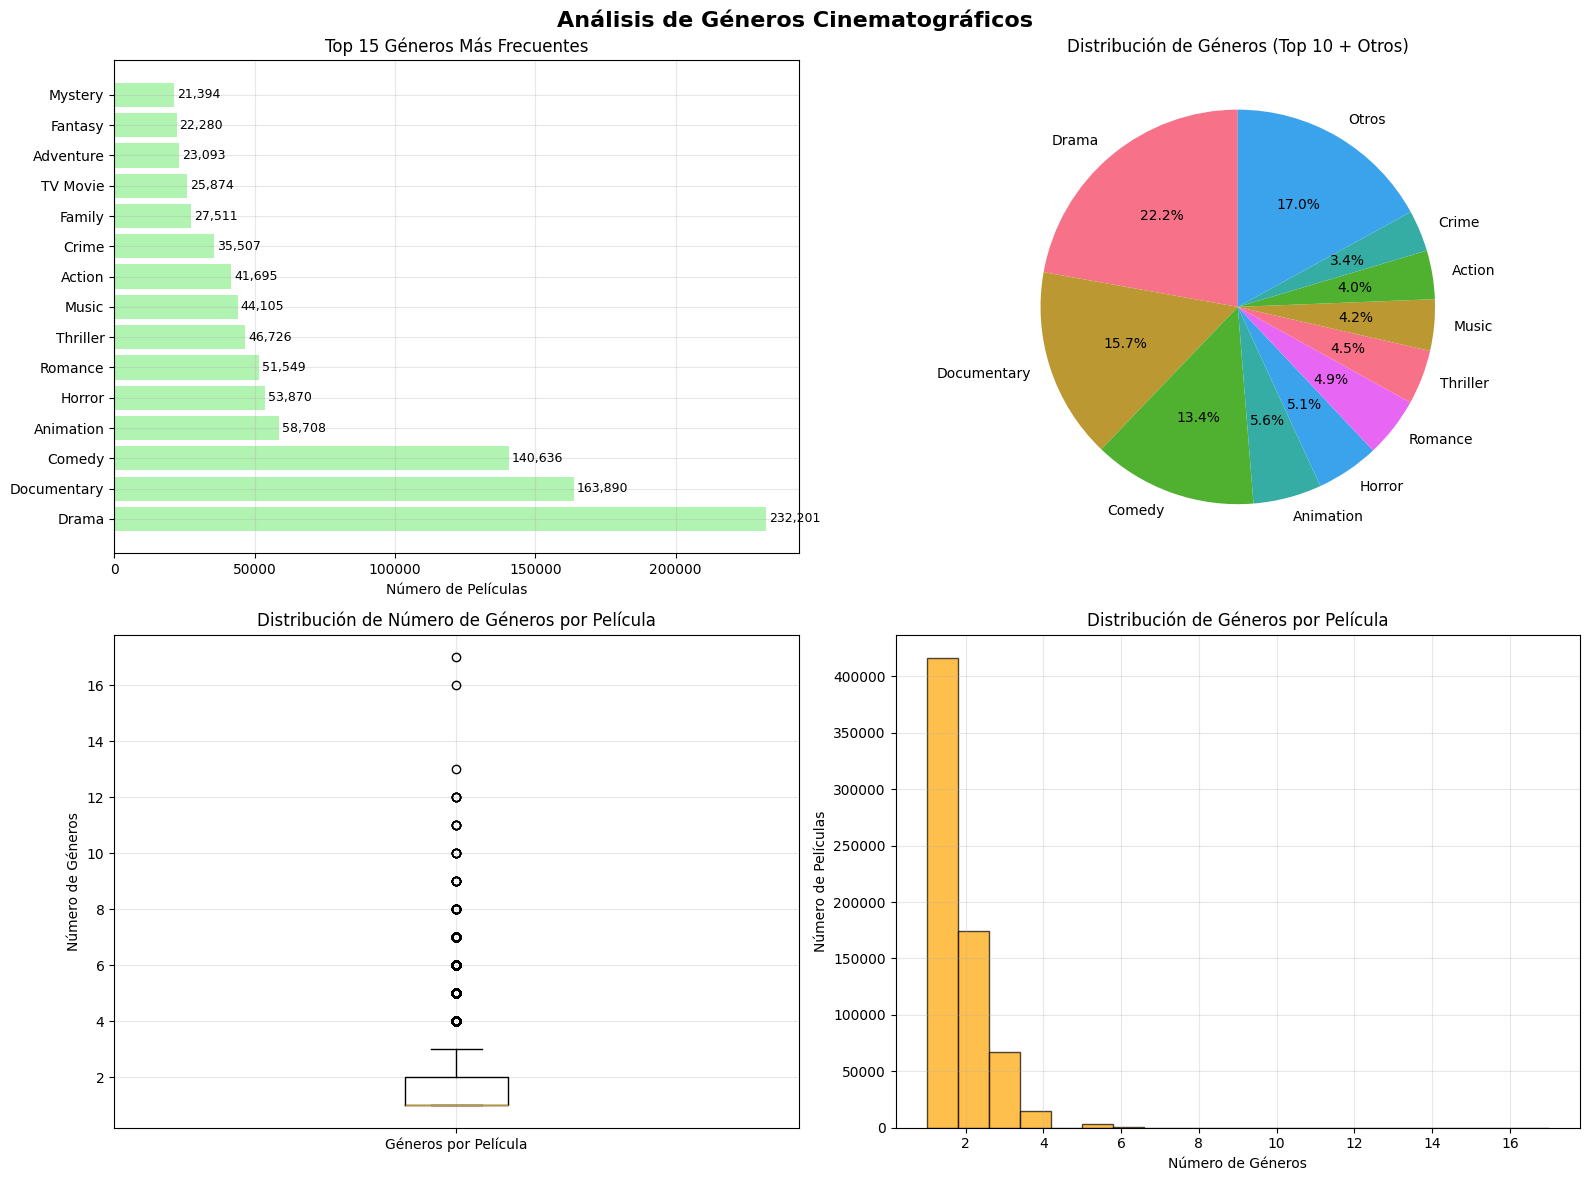

Total de géneros únicos: 19
Total de películas: 676,491
Promedio de géneros por película: 1.55
Mediana de géneros por película: 1
Género más común: Drama (232,201 películas)


In [12]:
# Análisis de géneros
genres_df = dfs["genres"].copy()

# Top 15 géneros más frecuentes
top_genres = genres_df['genre'].value_counts().head(15)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Géneros Cinematográficos', fontsize=16, fontweight='bold')

# 1. Gráfico de barras horizontal - Top 15 géneros
axes[0,0].barh(range(len(top_genres)), top_genres.values, color='lightgreen', alpha=0.7)
axes[0,0].set_yticks(range(len(top_genres)))
axes[0,0].set_yticklabels(top_genres.index)
axes[0,0].set_title('Top 15 Géneros Más Frecuentes')
axes[0,0].set_xlabel('Número de Películas')
axes[0,0].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(top_genres.values):
    axes[0,0].text(v + 1000, i, f'{v:,}', va='center', fontsize=9)

# 2. Gráfico de pastel - Top 10 géneros
top_10_genres = genres_df['genre'].value_counts().head(10)
other_count = genres_df['genre'].value_counts().iloc[10:].sum()
top_10_with_other = top_10_genres.copy()
top_10_with_other['Otros'] = other_count

axes[0,1].pie(top_10_with_other.values, labels=top_10_with_other.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribución de Géneros (Top 10 + Otros)')

# 3. Boxplot de distribución de géneros por película
movies_genre_count = genres_df.groupby('id').size()
axes[1,0].boxplot([movies_genre_count.values], labels=['Géneros por Película'])
axes[1,0].set_title('Distribución de Número de Géneros por Película')
axes[1,0].set_ylabel('Número de Géneros')
axes[1,0].grid(True, alpha=0.3)

# 4. Histograma de géneros por película
axes[1,1].hist(movies_genre_count.values, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_title('Distribución de Géneros por Película')
axes[1,1].set_xlabel('Número de Géneros')
axes[1,1].set_ylabel('Número de Películas')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total de géneros únicos: {genres_df['genre'].nunique()}")
print(f"Total de películas: {genres_df['id'].nunique():,}")
print(f"Promedio de géneros por película: {movies_genre_count.mean():.2f}")
print(f"Mediana de géneros por película: {movies_genre_count.median():.0f}")
print(f"Género más común: {top_genres.index[0]} ({top_genres.iloc[0]:,} películas)")


## Conclusión de calidad
------------------------------

*   Los datasets **son aptos** para continuar con el análisis, con las siguientes **condiciones** ya identificadas:
    
    1.  **Excluir rating** (alta ausencia).
        
    2.  **Filtrar fechas a 2000–2019** y usar **primera fecha por película** para evitar reestrenos múltiples.
        
    3.  **Normalizar** el país “Estados Unidos” y otras variantes.
        
    4.  **Verificar/deduplicar** claves lógicas: releases (id, country, type, date), genres (id, genre), countries (id, country).
        
*   Estas acciones se **documentan ahora** y se **ejecutarán en Fase 3 (Preparación de datos)**.